In [25]:
from glob import glob
from matplotlib import pyplot as plt
import numpy as np
import os
from skimage.io import imread, imshow
import numpy as np
import pandas as pd
import seaborn as sns
import df_utils
from pytorch_lightning import seed_everything
from sklearn.model_selection import train_test_split

!pwd
# os.chdir('../')
# !pwd

/home/genrev_kiel_hizon/SAR_flood_segmentation/src


## Generate Annotations CSV

In [2]:
seed_everything(42, workers=True)

Global seed set to 42


42

In [3]:
train_df = df_utils.create_df('../data/train/train/')
train_df.head()

,vv_image_path,vh_image_path,flood_label_path,water_body_label_path,region
0,../data/train/train/bangladesh_20170314t115609...,../data/train/train/bangladesh_20170314t115609...,../data/train/train/bangladesh_20170314t115609...,../data/train/train/bangladesh_20170314t115609...,bangladesh
1,../data/train/train/bangladesh_20170314t115609...,../data/train/train/bangladesh_20170314t115609...,../data/train/train/bangladesh_20170314t115609...,../data/train/train/bangladesh_20170314t115609...,bangladesh
2,../data/train/train/bangladesh_20170314t115609...,../data/train/train/bangladesh_20170314t115609...,../data/train/train/bangladesh_20170314t115609...,../data/train/train/bangladesh_20170314t115609...,bangladesh
3,../data/train/train/bangladesh_20170314t115609...,../data/train/train/bangladesh_20170314t115609...,../data/train/train/bangladesh_20170314t115609...,../data/train/train/bangladesh_20170314t115609...,bangladesh
4,../data/train/train/bangladesh_20170314t115609...,../data/train/train/bangladesh_20170314t115609...,../data/train/train/bangladesh_20170314t115609...,../data/train/train/bangladesh_20170314t115609...,bangladesh


In [4]:
test_df = df_utils.create_df('../data/val_with_ref_labels/test')
test_df.head()

,vv_image_path,vh_image_path,flood_label_path,water_body_label_path,region
0,../data/val_with_ref_labels/test/florence_2018...,../data/val_with_ref_labels/test/florence_2018...,../data/val_with_ref_labels/test/florence_2018...,../data/val_with_ref_labels/test/florence_2018...,florence
1,../data/val_with_ref_labels/test/florence_2018...,../data/val_with_ref_labels/test/florence_2018...,../data/val_with_ref_labels/test/florence_2018...,../data/val_with_ref_labels/test/florence_2018...,florence
2,../data/val_with_ref_labels/test/florence_2018...,../data/val_with_ref_labels/test/florence_2018...,../data/val_with_ref_labels/test/florence_2018...,../data/val_with_ref_labels/test/florence_2018...,florence
3,../data/val_with_ref_labels/test/florence_2018...,../data/val_with_ref_labels/test/florence_2018...,../data/val_with_ref_labels/test/florence_2018...,../data/val_with_ref_labels/test/florence_2018...,florence
4,../data/val_with_ref_labels/test/florence_2018...,../data/val_with_ref_labels/test/florence_2018...,../data/val_with_ref_labels/test/florence_2018...,../data/val_with_ref_labels/test/florence_2018...,florence


## Find images with flooding


In [5]:
# train_df = train_df.sample(5)
# test_df = test_df.sample(5)

In [6]:
train_df['has_mask'] = train_df['flood_label_path'].apply(df_utils.has_mask)
test_df['has_mask'] = test_df['flood_label_path'].apply(df_utils.has_mask)

In [7]:
train_df['has_mask'].value_counts()

False    22471
True     10934
Name: has_mask, dtype: int64

In [8]:
test_df['has_mask'].value_counts()

False    7290
True     3110
Name: has_mask, dtype: int64

## Find images where the satellite image is binary (invalid)
Invalid criteria:
- Binary SAR image
- 95%+ of pixels are cropped out areas ('1')
- 95%+ of pixels are open water
    - Either the SAR images are 95%+ black ('0')
    - or the Water label is 95%+ white ('1')

In [9]:
train_df = train_df.apply(lambda row: df_utils.remove_binary(row), axis=1)
test_df = test_df.apply(lambda row: df_utils.remove_binary(row), axis=1)

In [10]:
train_df.head()

,vv_image_path,vh_image_path,flood_label_path,water_body_label_path,region,has_mask,invalid
0,../data/train/train/bangladesh_20170314t115609...,../data/train/train/bangladesh_20170314t115609...,../data/train/train/bangladesh_20170314t115609...,../data/train/train/bangladesh_20170314t115609...,bangladesh,False,True
1,../data/train/train/bangladesh_20170314t115609...,../data/train/train/bangladesh_20170314t115609...,../data/train/train/bangladesh_20170314t115609...,../data/train/train/bangladesh_20170314t115609...,bangladesh,False,True
2,../data/train/train/bangladesh_20170314t115609...,../data/train/train/bangladesh_20170314t115609...,../data/train/train/bangladesh_20170314t115609...,../data/train/train/bangladesh_20170314t115609...,bangladesh,False,True
3,../data/train/train/bangladesh_20170314t115609...,../data/train/train/bangladesh_20170314t115609...,../data/train/train/bangladesh_20170314t115609...,../data/train/train/bangladesh_20170314t115609...,bangladesh,False,True
4,../data/train/train/bangladesh_20170314t115609...,../data/train/train/bangladesh_20170314t115609...,../data/train/train/bangladesh_20170314t115609...,../data/train/train/bangladesh_20170314t115609...,bangladesh,False,True


## Split test -> test, val
- 20% validation set to prevent overfitting
- 80% final testing set

In [11]:
val, test = train_test_split(test_df, stratify=test_df['has_mask'], test_size=0.8)

## Save final product to CSV

In [12]:
train_df.to_csv('../data/train.csv')
val.to_csv('../data/val.csv')
test.to_csv('../data/test.csv')

## Exploration

In [13]:
print(f'Train: {train_df.shape}')
print(f'Val: {val.shape}')
print(f'Test: {test.shape}')

Train: (33405, 7)
Val: (2080, 7)
Test: (8320, 7)


In [26]:
train_df = pd.read_csv('../data/train.csv', index_col=0)
train_df['Set'] = 'Train'

val_df = pd.read_csv('../data/val.csv', index_col=0)
val_df['Set'] = 'Val'

test_df = pd.read_csv('../data/test.csv', index_col=0)
test_df['Set'] = 'Test'

df = pd.concat([train_df, val_df, test_df])
pd.pivot_table(df, values='vh_image_path', index=['region'], columns = ['Set'],
               aggfunc='count', margins=True)

Set,Test,Train,Val,All
region,,,,
bangladesh,NaN,6204.0,NaN,6204
florence,8320.0,NaN,2080.0,10400
nebraska,NaN,12225.0,NaN,12225
northal,NaN,14976.0,NaN,14976
All,8320.0,33405.0,2080.0,43805


In [27]:
pd.pivot_table(df, values='vh_image_path', index=['Set'], columns = ['invalid', 'has_mask'],
               aggfunc='count', margins=True)

invalid   False          True         All
has_mask  False   True  False True       
Set                                      
Test       1756   2423   4076   65   8320
Train     14358  10271   8113  663  33405
Val         434    607   1024   15   2080
All       16548  13301  13213  743  43805

In [44]:
def s1_to_rgb(vv_image, vh_image):
    # ratio_image = np.clip(np.nan_to_num(vh_image / vv_image, 0), 0, 1)
    ratio_image = np.clip(np.nan_to_num(vh_image / vv_image, 0), 0, 1)
    rgb_image = np.stack((vv_image, vh_image, 1-ratio_image), axis=2)
    return rgb_image

/tmp/ipykernel_218203/3984800362.py:3: RuntimeWarning: divide by zero encountered in divide
  ratio_image = np.clip(np.nan_to_num(vh_image / vv_image, 0), 0, 1)


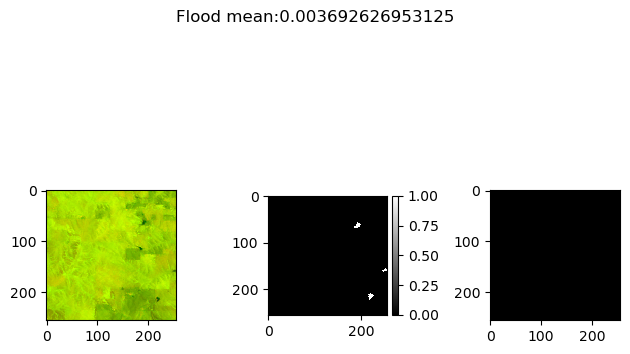

In [46]:
subset = df.loc[
        (df.Set == 'Train') &
        (df.invalid == False) &
        (df.has_mask == True)
    ].copy()
subset = subset.sample()

vv = imread(subset['vv_image_path'].values[0], as_gray=True)
vh = imread(subset['vh_image_path'].values[0], as_gray=True)
rgb_image = s1_to_rgb(vv, vh)
flood = imread(subset['flood_label_path'].values[0], as_gray=True)
water = imread(subset['water_body_label_path'].values[0], as_gray=True)

_, ax = plt.subplots(1,3)
plt.suptitle(f'Flood mean:{np.mean(flood)}')
imshow(rgb_image, ax=ax[0])
imshow(flood, ax=ax[1], cmap='gray')
imshow(water, ax=ax[2], cmap='gray')

In [33]:
channel_mean = np.std(rgb_image, axis=(0, 1))
channel_mean

array([0.08624411, 0.07206235, 0.00029001])